## Setup

In [ ]:
import cv2                              
import numpy as np                      
import os
import requests
import pickle
import glob  
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = [10, 10]

import pyheif
from PIL import Image

from scipy.optimize import least_squares
import scipy.interpolate
import plotly.express as px
import plotly.graph_objects as go

from pupil_apriltags import Detector

In [ ]:
# Fetch lists of target-IDs and 2D target locations (in inches) corresponding to the two
#   printed April boards.
response = requests.get("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")
data = pickle.loads(response.content)

at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

In [ ]:
!pip install opencv-python opencv-contrib-python-headless pupil-apriltags

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 8.3 MB/s eta 0:00:00


In [ ]:
#@title Helper function: `detect_aprilboard()`
# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=0.9,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

def detect_aprilboard(img, board, apriltag_detector):
    """
    Detects April tags in a grayscale image.

    Usage: imgpoints, objpoints, tag_ids = detect_aprilboard(img, board, AT_detector)

    Input:
        image -- grayscale image
        board -- at_coarseboard or at_fineboard (list of dictionaries)
        AT_detector -- AprilTag Detector parameters

    Returns:
        imgpoints -- Nx2 numpy array of (x,y) image coords
        objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
        tag_ids -- Nx1 list of tag IDs
    """

    imgpoints=[]
    objpoints=[]
    tagIDs=[]

    # detect april tags
    imgtags = apriltag_detector.detect(img,
                                    estimate_tag_pose=False,
                                    camera_params=None,
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))

        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))

            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])

            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))

            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])

    return imgpoints, objpoints, tagIDs

##Detect fiducials and calibrate camera

### Convert Images

In [ ]:
!pip install Pillow

### Calibrate

24 images:
0 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00019.JPG: 74 imgpts, 74 objpts
0 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00019.JPG: 0 imgpts, 0 objpts
1 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00020.JPG: 70 imgpts, 70 objpts
1 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00020.JPG: 0 imgpts, 0 objpts
2 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00002.JPG: 54 imgpts, 54 objpts
2 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00002.JPG: 10 imgpts, 10 objpts
3 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00010.JPG: 70 imgpts, 70 objpts
3 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00010.JPG: 34 imgpts, 34 objpts
4 /content/drive/Shareddrives/ES1

6 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00024.JPG: 3 imgpts, 3 objpts
6 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00024.JPG: 1 imgpts, 1 objpts
7 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00001.JPG: 55 imgpts, 55 objpts
7 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00001.JPG: 0 imgpts, 0 objpts
8 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00021.JPG: 71 imgpts, 71 objpts
8 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00021.JPG: 0 imgpts, 0 objpts
9 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00005.JPG: 67 imgpts, 67 objpts
9 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00005.JPG: 29 imgpts, 29 objpts
10 /content/drive/Shareddrives/ES143/Final_Proje

15 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00013.JPG: 9 imgpts, 9 objpts
15 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00013.JPG: 8 imgpts, 8 objpts
16 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00018.JPG: 75 imgpts, 75 objpts
16 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00018.JPG: 0 imgpts, 0 objpts
17 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00007.JPG: 71 imgpts, 71 objpts
17 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00007.JPG: 35 imgpts, 35 objpts
18 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00016.JPG: 45 imgpts, 45 objpts
18 /content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/playroom_es143_small_00016.JPG: 0 imgpts, 0 objpts
19 /content/drive/Shareddrives/ES143/Fin

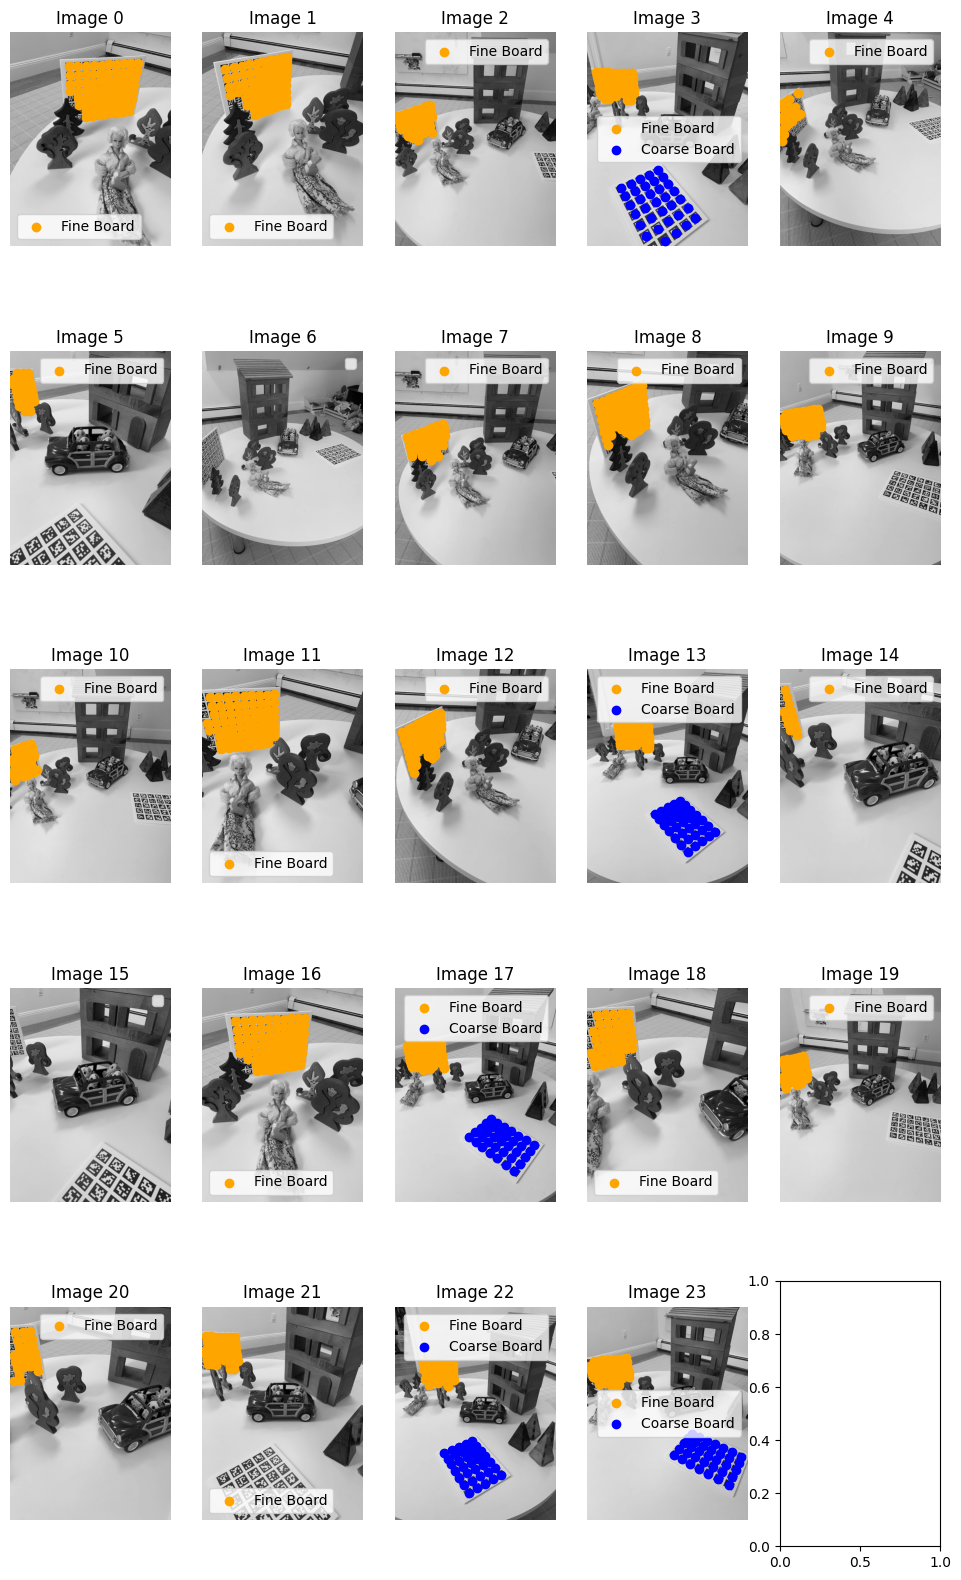

In [ ]:
#@title detect fiducials
N = 10
m = 30
total_validf = 0
total_validc = 0


# Edit this line to point to the collection of input calibration image
CALIBFILES = '/content/drive/Shareddrives/ES143/Final_Project/dataset/playroom/*.JPG'

# Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
BOARD_f = at_fineboard
BOARD_c = at_coarseboard

###### BEGIN CALIBRATION SCRIPT

# exit if no images are found or if BOARD is unrecognized
images = glob.glob(CALIBFILES)
assert images, "no calibration images matching: " + CALIBFILES
assert BOARD_f==at_fineboard or BOARD_c==at_coarseboard, "Unrecognized AprilBoard"

# else continue
print("{} images:".format(len(images)))

# initialize 3D object points and 2D image points
calObjPointsc = []
calImgPointsc = []
calObjPointsf = []
calImgPointsf = []

# define the number of columns for the plot, then calculate number of rows
num_plot_cols = 5
num_plot_rows = (len(images) + num_plot_cols - 1) // num_plot_cols

# create the figure and axes; flatten the axes array for convenvience
fig, axs = plt.subplots(num_plot_rows, num_plot_cols, figsize=(12, 4*num_plot_rows))
axs = axs.flatten()

for count, fname in enumerate(images):
    # read image and convert to grayscale if necessary
    orig = cv2.imread(fname)
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    else:
        img = orig

    axs[count].imshow(img, cmap="gray")
    axs[count].set_title(f"Image {count}")
    axs[count].axis('off')

    # Detect AprilTags
    imgpointsf, objpointsf, tagIDsf = detect_aprilboard(img, BOARD_f, at_detector)
    imgpointsc, objpointsc, tagIDsc = detect_aprilboard(img, BOARD_c, at_detector)
    print(f"{count} {fname}: {len(imgpointsf)} imgpts, {len(objpointsf)} objpts")
    print(f"{count} {fname}: {len(imgpointsc)} imgpts, {len(objpointsc)} objpts")

    # Check valid detections and accumulate
    if len(imgpointsf) >= N and len(objpointsf) >= N:
        total_validf += 1
        calObjPointsf.append(objpointsf.astype(np.float32))
        calImgPointsf.append(imgpointsf.astype(np.float32))
        axs[count].scatter(imgpointsf[:, 0], imgpointsf[:, 1], color='orange', label='Fine Board')

    if len(imgpointsc) >= m and len(objpointsc) >= m:
        total_validc += 1
        calObjPointsc.append(objpointsc.astype(np.float32))
        calImgPointsc.append(imgpointsc.astype(np.float32))
        axs[count].scatter(imgpointsc[:, 0], imgpointsc[:, 1], color='blue', label='Coarse Board')

    axs[count].legend()

plt.show()

In [ ]:
#@title calibrate camera

# calibrate the camera
reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
    calObjPointsf,
    calImgPointsf,
    img.shape,    # uses image H,W to initialize the principal point to (H/2,W/2)
    None,         # no initial guess for the remaining entries of calMatrix
    None,         # initial guesses for distortion coefficients are all 0
    flags = None) # default contstraints (see documentation)

reprojerr1, calMatrix1, distCoeffs1, calRotations1, calTranslations1 = cv2.calibrateCamera(
    calObjPointsc,
    calImgPointsc,
    img.shape,
    None,
    None,
    flags = None)


In [ ]:
np.set_printoptions(precision=2, suppress=True)

print('RMSE of reprojected points:', reprojerr)
print('Distortion coefficients:', distCoeffs)
print('Intrinsic camera matrix:\n', calMatrix)
print('Total images used for calibration: ', total_validf)

print('\n')

print('RMSE of reprojected points1:', reprojerr1)
print('Distortion coefficients:', distCoeffs1)
print('Intrinsic camera matrix:\n', calMatrix1)
print('Total images used for calibration: ', total_validc)

RMSE of reprojected points: 0.28315039331769254
Distortion coefficients: [[ 0.09 -0.3  -0.01  0.02  0.37]]
Intrinsic camera matrix:
 [[777.23   0.   436.28]
 [  0.   791.6  431.6 ]
 [  0.     0.     1.  ]]
Total images used for calibration:  22


RMSE of reprojected points1: 1.9786839124507725
Distortion coefficients: [[ 0.21  0.3   0.06 -0.01 -0.03]]
Intrinsic camera matrix:
 [[1320.26    0.    492.37]
 [   0.    434.44  185.56]
 [   0.      0.      1.  ]]
Total images used for calibration:  5


In [ ]:
#@title Compute reprojection error separately in each image with fine boards

# initial array for storing per-image reprojection errors
mean_errors=[]

# project 3D board points into the images, and compute the per-image reprojection error
for i in range(len(calObjPointsf)):
    imgpoints2, _ = cv2.projectPoints(calObjPointsf[i], calRotations[i], calTranslations[i], calMatrix, distCoeffs)
    mean_errors.append(np.mean(np.linalg.norm(calImgPointsf[i] - np.squeeze(imgpoints2),axis=1)))

# Print the list of per-image reprojection errors with at most 5 elements per line
print('\n'.join([', '.join([f"{error:.{5}f}" for error in mean_errors[i:i+5]]) for i in range(0, len(mean_errors), 5)]))


0.31679, 0.35433, 0.11242, 0.20255, 0.14767
0.19576, 0.18840, 0.28460, 0.14264, 0.07692
0.31486, 0.24869, 0.20080, 0.20486, 0.40989
0.20006, 0.16001, 0.09260, 0.23840, 0.18831
0.21533, 0.12995


In [ ]:
mean_errors_c = []  

for i in range(len(calObjPointsc)):
    imgpoints3, _ = cv2.projectPoints(calObjPointsc[i], calRotations1[i], calTranslations1[i], calMatrix1, distCoeffs1)
    errors = np.linalg.norm(calImgPointsc[i] - np.squeeze(imgpoints3), axis=1)
    mean_errors_c.append(np.mean(errors))

print("\n", mean_errors_c)


 [2.0660686, 1.6591816, 1.3895143, 1.3200545, 1.6965804]


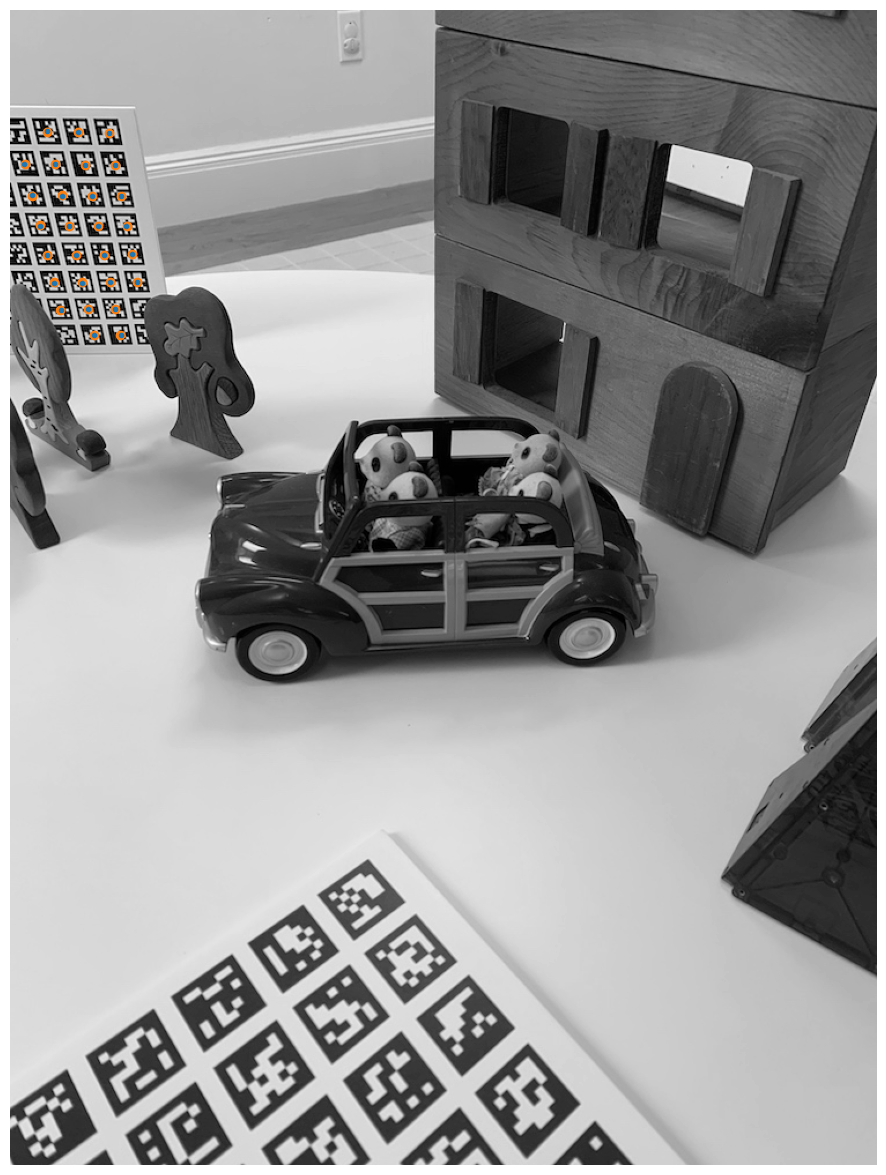

In [ ]:
#@title Display the projected points in one of the images

IMNUM= 5

# read image and convert to grayscale if necessary
orig = cv2.imread(images[IMNUM])
if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
else:
    img = orig

fig,ax =plt.subplots(figsize=(15,15))
ax.imshow(img / 255.0, cmap="gray")
ax.set_axis_off()

ax.scatter(calImgPointsf[IMNUM][:,0], calImgPointsf[IMNUM][:,1], marker='o', color='#ff7f0e')
# ax.scatter(calImgPointsc[IMNUM][:,0], calImgPointsc[IMNUM][:,1], marker='o', color='#ff7f0e')


# compute reprojections
imgpoints2, _ = cv2.projectPoints(calObjPointsf[IMNUM],
                                  calRotations[IMNUM],
                                  calTranslations[IMNUM],
                                  calMatrix, distCoeffs)
imgpoints3, _ = cv2.projectPoints(calObjPointsc[IMNUM],
                                  calRotations1[IMNUM],
                                  calTranslations1[IMNUM],
                                  calMatrix1, distCoeffs1)
imgpoints2=np.squeeze(imgpoints2) # eliminate the leading single dimension
imgpoints3=np.squeeze(imgpoints3) # eliminate the leading single dimension


# show reprojected points (in blue)
ax.scatter(imgpoints2[:,0], imgpoints2[:,1], marker='.', color='#1f77b4')
ax.scatter(imgpoints3[:,0], imgpoints3[:,1], marker='.', color='#1f77b4')